#　有名なモデルを実装

## LeNet

In [1]:
import torch
import numpy 
import matplotlib.pyplot as plt

from torch import nn, optim
import torchvision
import torch.nn.functional as F

from torchvision import models, transforms
from torchvision.models.vgg import VGG11_Weights

from torch.utils.data import DataLoader, Subset
%load_ext autoreload
%autoreload 2
import utils
import time


In [ ]:
今回は入力画像を用意するよりも、適当なtensorを用意して学習さえる

In [30]:
class LeNet(nn.Module):

    def __init__(self):
        super().__init__()
        # kernel_size, stride, paddingは出力のサイズの式から逆算する
        self.conv1 = nn.Conv2d(1,6, kernel_size=5)
        self.conv2 = nn.Conv2d(6,16, kernel_size=5)
        self.flatten = nn.Flatten()
        # 16x5x5がinput
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        

    def forward(self, X):
        """
        block化
        F.max_pool2d(F.relu(self.conv1(X)), 2)
        """
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2)
        
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2)

        X = self.flatten(X)

        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        
        return X

In [31]:
X = torch.randn((128, 1, 32, 32))

In [32]:
model = LeNet()
out = model(X)
out.shape


torch.Size([128, 10])

In [34]:
LeNet()

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

## 既存のモデルの使用

In [2]:
model = models.vgg11(weights=VGG11_Weights.IMAGENET1K_V1)

In [4]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [5]:
model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): ReLU(inplace=True)
  (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (14): ReLU(inplace=True)
  (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (16): Conv2d(512, 512, kernel_size=(3, 3), stride=

In [3]:
# データ準備

transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5,0.5, 0.5), (0.5, 0.5, 0.5)),
    # CIFAR10用
    transforms.Normalize(mean=[0.4914,0.4822,0.4465], std=[0.2023,0.1994,0.2010]),

])

classes = ('airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'flog','horse', 'ship', 'truck')									

train_dataset = torchvision.datasets.CIFAR10('./cifar10_data', train=True, download=True, transform=transform)
val_dataset = torchvision.datasets.CIFAR10('./cifar10_data', train=False, download=True, transform=transform)

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
# val_loader = DataLoader(val_dataset, batch_size=32, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# subsetと使う
train_dataset_sub = Subset(train_dataset, range(1000))
val_dataset_sub = Subset(val_dataset, range(1000))

train_loader = DataLoader(train_dataset_sub, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset_sub, batch_size=32, num_workers=4)

In [77]:
# データ取得
im, label = train_dataset[0]

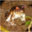

In [31]:
im

In [34]:
classes[label] 

'flog'

In [5]:
X_train, y_train = next(iter(train_loader))
print(X_train.shape)
print(y_train.shape)

torch.Size([32, 3, 32, 32])
torch.Size([32])


In [6]:
# optmizer作成
# model = models.vgg11(weights=VGG11_Weights.IMAGENET1K_V1)
opt = optim.SGD(model.parameters(), lr=0.03)

In [7]:
out = model(X_train)

In [8]:
out.shape

torch.Size([32, 1000])

In [9]:
# 全結合層の出力が1000になっている。 -> 10クラス分類にする
model.classifier[-1]

Linear(in_features=4096, out_features=1000, bias=True)

In [10]:
# 上書きする
model.classifier[-1] = nn.Linear(4096, 10)

In [11]:
out = model(X_train)
out.shape

torch.Size([32, 10])

In [12]:
# これを学習する
start_time = time.time()
train_losses, val_losses, val_accuracy = utils.learn(model,train_loader,val_loader, opt, loss_func=F.cross_entropy, num_epoch=3)
end_time = time.time()
print("かかった時間:",end_time - start_time) 

epoch: 0: train error: 2.1117691434919834, validation error: 1.945731583982706, validation accuracy: 0.3017578125


epoch: 1: train error: 1.5884174797683954, validation error: 1.3757545109838247, validation accuracy: 0.4833984375


epoch: 2: train error: 1.2217957973480225, validation error: 1.4817619621753693, validation accuracy: 0.494140625
かかった時間: 379.3145351409912


In [13]:
# VGG11で, CIFAR10をCPUで回すと時間がかかる -> dataを減らす
len(train_dataset) / 32

1562.5